In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms

In [0]:
batch_size = 100

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))])

In [4]:
mnist = torchvision.datasets.MNIST(root='drive/My Drive/Colab Notebooks/data/', 
                                   train=True, 
                                   transform=transform, 
                                   download=True)

Extracting drive/My Drive/Colab Notebooks/data/MNIST/raw/train-images-idx3-ubyte.gz to drive/My Drive/Colab Notebooks/data/MNIST/raw


Extracting drive/My Drive/Colab Notebooks/data/MNIST/raw/train-labels-idx1-ubyte.gz to drive/My Drive/Colab Notebooks/data/MNIST/raw


Extracting drive/My Drive/Colab Notebooks/data/MNIST/raw/t10k-images-idx3-ubyte.gz to drive/My Drive/Colab Notebooks/data/MNIST/raw


Extracting drive/My Drive/Colab Notebooks/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to drive/My Drive/Colab Notebooks/data/MNIST/raw
Processing...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


In [0]:
data_loader = torch.utils.data.DataLoader(dataset=mnist, 
                                          batch_size=batch_size, 
                                          shuffle=True)

In [0]:
images, labels = iter(data_loader).next()

In [0]:
img = torchvision.utils.make_grid(images)
img = img.detach().numpy()
img = img.clip(0, 1)

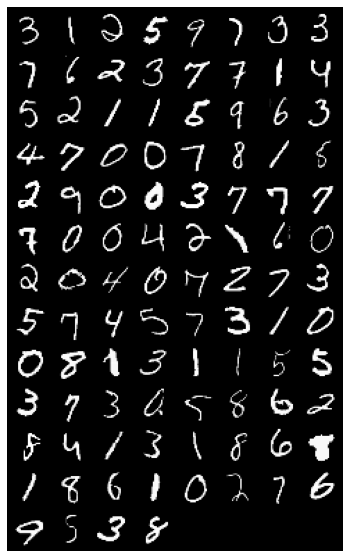

In [8]:
plt.figure(figsize=(12, 10))
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.axis('off')
plt.show()

In [0]:
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 100

In [0]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.5),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Dropout(0.5),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [0]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [0]:
D = D.to(device)
G = G.to(device)

In [0]:
bce_loss = nn.BCELoss()

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [0]:
total_step = len(data_loader)

In [16]:
for epoch in range(num_epochs):

  for i, (images, _) in enumerate(data_loader):

    images = images.reshape(batch_size, -1).to(device)

    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    outputs = D(images)

    d_loss_real = bce_loss(outputs, real_labels)
    real_score = outputs

    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)

    outputs = D(fake_images)

    d_loss_fake = bce_loss(outputs, fake_labels)
    fake_score = outputs

    d_loss = d_loss_real + d_loss_fake

    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

    d_loss.backward()
    d_optimizer.step()

    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)

    g_loss = bce_loss(outputs, real_labels)

    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

    g_loss.backward()
    g_optimizer.step()

    if (i+1) % 200 == 0:
      print('Epoch: [{}/{}], Step: [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:2f}'
            .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                    real_score.mean().item(), fake_score.mean().item()))
    
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)

Epoch: [0/100], Step: [200/600], d_loss: 0.0806, g_loss: 5.1591, D(x): 0.98, D(G(z)): 0.053407
Epoch: [0/100], Step: [400/600], d_loss: 1.0653, g_loss: 2.1168, D(x): 0.75, D(G(z)): 0.439170
Epoch: [0/100], Step: [600/600], d_loss: 0.1191, g_loss: 5.3683, D(x): 0.95, D(G(z)): 0.058610
Epoch: [1/100], Step: [200/600], d_loss: 0.2881, g_loss: 3.4651, D(x): 0.91, D(G(z)): 0.128613
Epoch: [1/100], Step: [400/600], d_loss: 1.2211, g_loss: 1.3771, D(x): 0.68, D(G(z)): 0.430604
Epoch: [1/100], Step: [600/600], d_loss: 0.5808, g_loss: 2.4992, D(x): 0.83, D(G(z)): 0.248588
Epoch: [2/100], Step: [200/600], d_loss: 0.8300, g_loss: 1.6199, D(x): 0.76, D(G(z)): 0.346193
Epoch: [2/100], Step: [400/600], d_loss: 0.4886, g_loss: 2.4416, D(x): 0.81, D(G(z)): 0.164195
Epoch: [2/100], Step: [600/600], d_loss: 0.5992, g_loss: 1.8894, D(x): 0.88, D(G(z)): 0.280239
Epoch: [3/100], Step: [200/600], d_loss: 0.4004, g_loss: 3.0199, D(x): 0.86, D(G(z)): 0.121748
Epoch: [3/100], Step: [400/600], d_loss: 0.4283, g

In [0]:
img = torchvision.utils.make_grid(fake_images)
img = img.detach().cpu().numpy()
img = img.clip(0, 1)

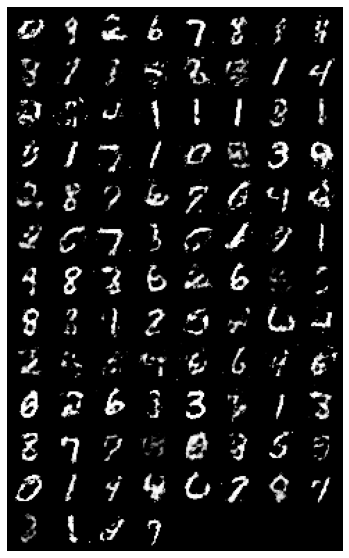

In [20]:
plt.figure(figsize=(12, 10))
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.axis('off')
plt.show()